In [227]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, LSTM


In [228]:
df=pd.read_csv('m2_s2_bank_fd9e1495674488429597135792319d60__site_1239fca6caf920448b3cd13f6a2997af.csv')
df=df[df['CellNo']==1].reset_index(drop=True)
df=df['ResistValue']
df

0      0.444
1      0.441
2      0.437
3      0.436
4      0.436
       ...  
649    0.384
650    0.385
651    0.382
652    0.388
653    0.389
Name: ResistValue, Length: 654, dtype: float64

In [229]:
def error_rate(original, prediction, ft_len, forecast_len):
    error_avg = []
    ft_len = ft_len-1
    for i in range(forecast_len):
        error = abs((original[ft_len+forecast_len+i] - prediction[ft_len+i]))/original[ft_len+i] * 100
        print('num',i,error,'actual',original[ft_len+forecast_len+i],'prediction',predictions[ft_len+i])
        print("오차율 :",error)
        error_avg.append(error)
    print('최소 오류값 :',min(error_avg))
    print('최대 오류값 :',max(error_avg))
    return sum(error_avg)/len(error_avg)


In [230]:

def kalman_filter(z_meas, x_esti, P):
    """Kalman Filter Algorithm for One Variable."""
    # (1) Prediction.
    x_pred = A * x_esti
    P_pred = A * P * A + Q

    # (2) Kalman Gain.
    K = P_pred * H / (H * P_pred * H + R)

    # (3) Estimation.
    x_esti = x_pred + K * (z_meas - H * x_pred)

    # (4) Error Covariance.
    P = P_pred - K * H * P_pred

    return x_esti, P
# Initialization for system model.
A = 1
H = 1
Q = 0.0001
R = 0.001
# Initialization for estimation.
x_0 = 10  # 14 for book.
P_0 = 6

In [231]:
def make_dataset(data, label, window_size):
    feature_list = []
    label_list = []
    for i in range(len(data) - (window_size+20)):
        feature_list.append(np.array(data.iloc[i:i+window_size]))
        label_list.append(np.array(label.iloc[i+window_size+window_size-1]))
    return np.array(feature_list), np.array(label_list)

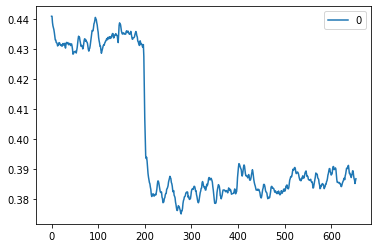

In [232]:
n_samples = len(df)
x_0 = df[1]
r_meas_save = np.zeros(n_samples)
r_esti_save = np.zeros(n_samples)

x_esti, P = None, None
for i in range(n_samples):
    r_meas = df[i]
    if i == 0:
        x_esti, P = x_0, P_0
    else:
        x_esti, P = kalman_filter(r_meas, x_esti, P)
        # print(x_esti[1])
    r_meas_save[i] = r_meas
    r_esti_save[i] = x_esti

#print("123", x_esti)

df = r_esti_save
tt=pd.DataFrame(df)
tt.plot()

In [233]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scale_cols = ['ResistValue']
df = pd.DataFrame(df)
df.columns = scale_cols
df_scaled = scaler.fit_transform(df[scale_cols])

df_scaled = pd.DataFrame(df_scaled)
df_scaled.columns = scale_cols

In [234]:
train=df_scaled
feature_cols = ['ResistValue']
label_cols = ['ResistValue']

train_feature = train[feature_cols]
train_label = train[label_cols]
# test_feature = test[feature_cols]
# test_label = test[label_cols]



In [235]:
train_feature, train_label = make_dataset(train_feature, train_label, 20)
total_len = len(train_feature)

x_train = train_feature[:int(total_len*0.8)]
x_valid = train_feature[int(total_len*0.8):]
y_train = train_label[:int(total_len*0.8)]
y_valid = train_label[int(total_len*0.8):]

In [236]:
model= Sequential()
model.add(LSTM(128, input_shape=(x_train.shape[1], x_train.shape[2]), 
               activation='relu'))
model.add(Dense(64))
model.add(Dense(32))
model.add(Dense(1))
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 128)               66560     
_________________________________________________________________
dense_8 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_9 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 33        
Total params: 76,929
Trainable params: 76,929
Non-trainable params: 0
_________________________________________________________________


In [237]:
from keras.callbacks import EarlyStopping
model.compile(loss='mse', optimizer='adam', metrics=['mse'])
early_stop=EarlyStopping(monitor='val_loss', patience=5)

model.fit(x_train, y_train, epochs=100, batch_size=1)
model.save('testmodel.h5')

Epoch 1/100
491/491 [==============================] - 5s 7ms/step - loss: 0.0300 - mse: 0.0300
Epoch 2/100
491/491 [==============================] - 3s 7ms/step - loss: 0.0365 - mse: 0.0365
Epoch 3/100
491/491 [==============================] - 4s 7ms/step - loss: 0.0193 - mse: 0.0193
Epoch 4/100
491/491 [==============================] - 3s 7ms/step - loss: 0.0235 - mse: 0.0235
Epoch 5/100
491/491 [==============================] - 3s 7ms/step - loss: 0.0198 - mse: 0.0198
Epoch 6/100
491/491 [==============================] - 4s 7ms/step - loss: 0.0239 - mse: 0.0239
Epoch 7/100
491/491 [==============================] - 4s 7ms/step - loss: 0.0195 - mse: 0.0195
Epoch 8/100
491/491 [==============================] - 3s 7ms/step - loss: 0.0248 - mse: 0.0248
Epoch 9/100
491/491 [==============================] - 3s 7ms/step - loss: 0.0262 - mse: 0.0262
Epoch 10/100
491/491 [==============================] - 3s 7ms/step - loss: 0.0208 - mse: 0.0208
Epoch 11/100
491/491 [=================

# TESTING

num 0 [0.88471779] actual [0.40993996] prediction [0.40631682]
오차율 : [0.88471779]
num 1 [0.49261375] actual [0.4110368] prediction [0.40902013]
오차율 : [0.49261375]
num 2 [0.17060007] actual [0.4083253] prediction [0.4090203]
오차율 : [0.17060007]
num 3 [0.81469637] actual [0.40634632] prediction [0.4030326]
오차율 : [0.81469637]
num 4 [0.35560162] actual [0.40625276] prediction [0.4048071]
오차율 : [0.35560162]
num 5 [0.19451612] actual [0.40699495] prediction [0.4062034]
오차율 : [0.19451612]
num 6 [0.37378883] actual [0.40780678] prediction [0.4062826]
오차율 : [0.37378883]
num 7 [0.30730062] actual [0.40812914] prediction [0.40687588]
오차율 : [0.30730062]
num 8 [0.57879587] actual [0.40890472] prediction [0.40654865]
오차율 : [0.57879587]
num 9 [0.05242235] actual [0.40811999] prediction [0.4079069]
오차율 : [0.05242235]
num 10 [0.56291955] actual [0.40727711] prediction [0.40498653]
오차율 : [0.56291955]
num 11 [0.506505] actual [0.4074724] prediction [0.40540305]
오차율 : [0.506505]
num 12 [0.28836764] actual 

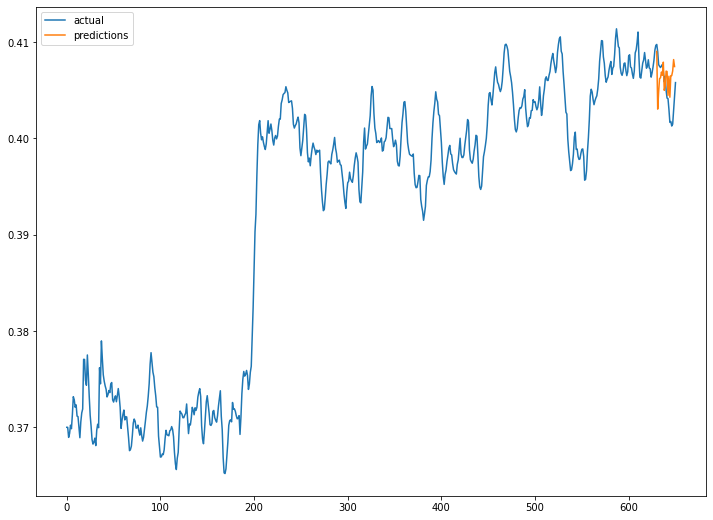

In [238]:
df=pd.read_csv('m2_s2_bank_fd9e1495674488429597135792319d60__site_1239fca6caf920448b3cd13f6a2997af.csv')
df=df[df['CellNo']==23].reset_index(drop=True)
x_test2=df['ResistValue']
n_samples=len(x_test2)
x_0 = x_test2[1]

r_meas_save = np.zeros(n_samples)
r_esti_save = np.zeros(n_samples)

x_esti, P = None, None
for i in range(n_samples):
    r_meas = x_test2[i]
    if i == 0:
        x_esti, P = x_0, P_0
    else:
        x_esti, P = kalman_filter(r_meas, x_esti, P)
        # print(x_esti[1])
    r_meas_save[i] = r_meas
    r_esti_save[i] = x_esti

#print("123", x_esti)

x_test2 = r_esti_save

x_test2 = pd.DataFrame(x_test2)
x_test2.columns = scale_cols
x_test2 = scaler.fit_transform(x_test2)
x_test2 = pd.DataFrame(x_test2)
y_test2 = x_test2

train_feature2, train_label2 = make_dataset(x_test2, y_test2, 20)
predictions = model.predict(train_feature2)

# Inversing
predictions = scaler.inverse_transform(predictions)
x_test2 = scaler.inverse_transform(x_test2)


feature_len = len(x_test2)-1 
plot_len = feature_len-20

x_data = range(feature_len)
plt.figure(figsize=(12, 9))
plt.plot(x_test2[:], label ='actual')
plt.plot(x_data[plot_len:], predictions[plot_len-39:], label='predictions')
plt.legend()



feature_len = len(train_feature2) - 1
plot_len = feature_len-20
error= error_rate(x_test2, predictions, plot_len, 20)
print('평균 오차율 :',error)

num 0 [3.92020022] actual [0.44104939] prediction [0.4238087]
오차율 : [3.92020022]
num 1 [3.08273559] actual [0.44049573] prediction [0.42689475]
오차율 : [3.08273559]
num 2 [2.95545777] actual [0.44090212] prediction [0.42783234]
오차율 : [2.95545777]
num 3 [3.17434643] actual [0.44146888] prediction [0.42760456]
오차율 : [3.17434643]
num 4 [2.96861365] actual [0.44134221] prediction [0.4284387]
오차율 : [2.96861365]
num 5 [3.33809217] actual [0.44151991] prediction [0.42703444]
오차율 : [3.33809217]
num 6 [3.3252345] actual [0.44246008] prediction [0.42800295]
오차율 : [3.3252345]
num 7 [3.19430384] actual [0.44341641] prediction [0.42947477]
오차율 : [3.19430384]
num 8 [2.89584926] actual [0.44195313] prediction [0.429302]
오차율 : [2.89584926]
num 9 [3.52007947] actual [0.44088517] prediction [0.4254772]
오차율 : [3.52007947]
num 10 [3.11414501] actual [0.44037588] prediction [0.42671713]
오차율 : [3.11414501]
num 11 [2.94636447] actual [0.44027433] prediction [0.4273324]
오차율 : [2.94636447]
num 12 [3.25136828] ac

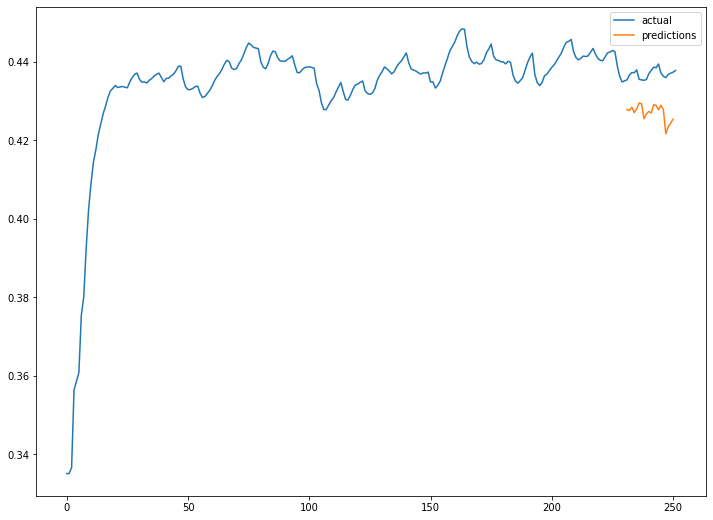

In [215]:
df=pd.read_csv('m2_s2_bank_4cb233e187db644297474c6d171dfaa6__site_0d39d11b52565146a236a646d49133f4.csv_23_3.csv')

x_test2=df['ResistValue']
n_samples=len(x_test2)
x_0 = x_test2[1]

r_meas_save = np.zeros(n_samples)
r_esti_save = np.zeros(n_samples)

x_esti, P = None, None
for i in range(n_samples):
    r_meas = x_test2[i]
    if i == 0:
        x_esti, P = x_0, P_0
    else:
        x_esti, P = kalman_filter(r_meas, x_esti, P)
        # print(x_esti[1])
    r_meas_save[i] = r_meas
    r_esti_save[i] = x_esti

#print("123", x_esti)

x_test2 = r_esti_save

x_test2 = pd.DataFrame(x_test2)
x_test2.columns = scale_cols
x_test2 = scaler.fit_transform(x_test2)
x_test2 = pd.DataFrame(x_test2)
y_test2 = x_test2

train_feature2, train_label2 = make_dataset(x_test2, y_test2, 20)
predictions = model.predict(train_feature2)

# Inversing
predictions = scaler.inverse_transform(predictions)
x_test2 = scaler.inverse_transform(x_test2)


feature_len = len(x_test2)-1 
plot_len = feature_len-20

x_data = range(feature_len)
plt.figure(figsize=(12, 9))
plt.plot(x_test2[:], label ='actual')
plt.plot(x_data[plot_len:], predictions[plot_len-39:], label='predictions')
plt.legend()



feature_len = len(train_feature2) - 1
plot_len = feature_len-20
error= error_rate(x_test2, predictions, plot_len, 20)
print('평균 오차율 :',error)

num 0 [1.91689996] actual [0.44447357] prediction [0.43591705]
오차율 : [1.91689996]
num 1 [1.85766237] actual [0.44434563] prediction [0.4360253]
오차율 : [1.85766237]
num 2 [2.00603643] actual [0.44479257] prediction [0.4357529]
오차율 : [2.00603643]
num 3 [1.53297672] actual [0.44376798] prediction [0.4368419]
오차율 : [1.53297672]
num 4 [2.08150889] actual [0.44356051] prediction [0.4341494]
오차율 : [2.08150889]
num 5 [1.66393545] actual [0.44313893] prediction [0.43562087]
오차율 : [1.66393545]
num 6 [1.68546172] actual [0.44283124] prediction [0.43521968]
오차율 : [1.68546172]
num 7 [1.74477532] actual [0.44260667] prediction [0.43475837]
오차율 : [1.74477532]
num 8 [1.57145123] actual [0.44217262] prediction [0.43511167]
오차율 : [1.57145123]
num 9 [1.72001049] actual [0.44212599] prediction [0.43439904]
오차율 : [1.72001049]
num 10 [1.51726492] actual [0.44182179] prediction [0.43500254]
오차율 : [1.51726492]
num 11 [1.77286523] actual [0.44241025] prediction [0.43444434]
오차율 : [1.77286523]
num 12 [1.50166773

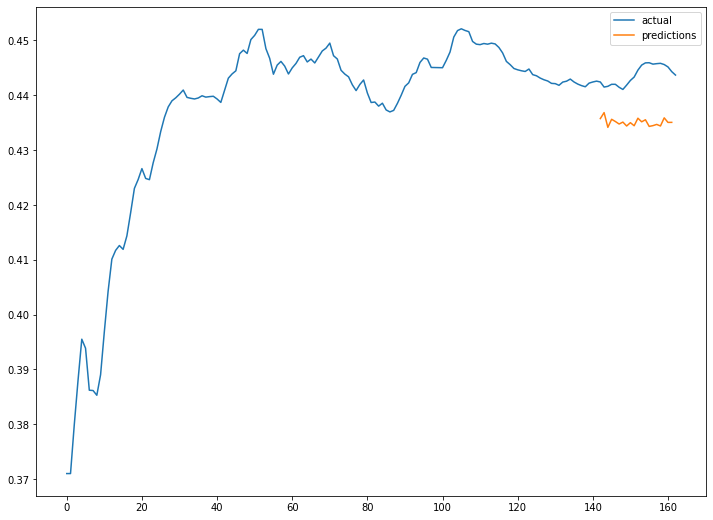

In [216]:
df=pd.read_csv('m2_s2_bank_7af47f8b99c60541bd4b40c0f19746af__site_1239fca6caf920448b3cd13f6a2997af.csv_54_2.csv')

x_test2=df['ResistValue']
n_samples=len(x_test2)
x_0 = x_test2[1]

r_meas_save = np.zeros(n_samples)
r_esti_save = np.zeros(n_samples)

x_esti, P = None, None
for i in range(n_samples):
    r_meas = x_test2[i]
    if i == 0:
        x_esti, P = x_0, P_0
    else:
        x_esti, P = kalman_filter(r_meas, x_esti, P)
        # print(x_esti[1])
    r_meas_save[i] = r_meas
    r_esti_save[i] = x_esti

#print("123", x_esti)

x_test2 = r_esti_save

x_test2 = pd.DataFrame(x_test2)
x_test2.columns = scale_cols
x_test2 = scaler.fit_transform(x_test2)
x_test2 = pd.DataFrame(x_test2)
y_test2 = x_test2

train_feature2, train_label2 = make_dataset(x_test2, y_test2, 20)
predictions = model.predict(train_feature2)

# Inversing
predictions = scaler.inverse_transform(predictions)
x_test2 = scaler.inverse_transform(x_test2)


feature_len = len(x_test2)-1 
plot_len = feature_len-20

x_data = range(feature_len)
plt.figure(figsize=(12, 9))
plt.plot(x_test2[:], label ='actual')
plt.plot(x_data[plot_len:], predictions[plot_len-39:], label='predictions')
plt.legend()



feature_len = len(train_feature2) - 1
plot_len = feature_len-20
error= error_rate(x_test2, predictions, plot_len, 20)
print('평균 오차율 :',error)

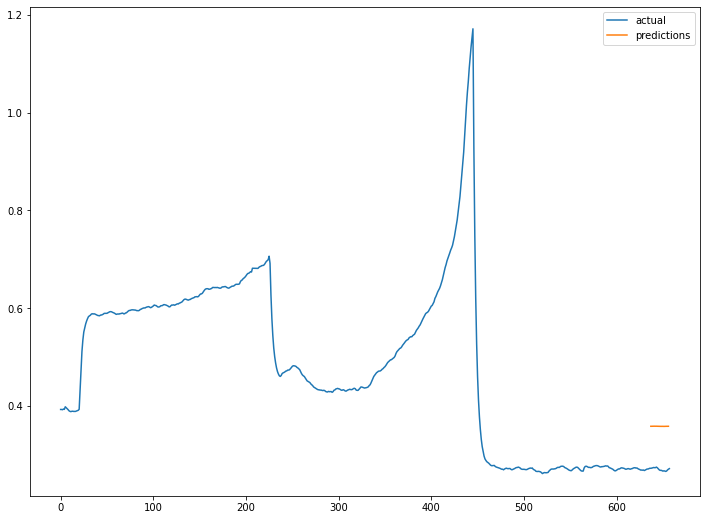

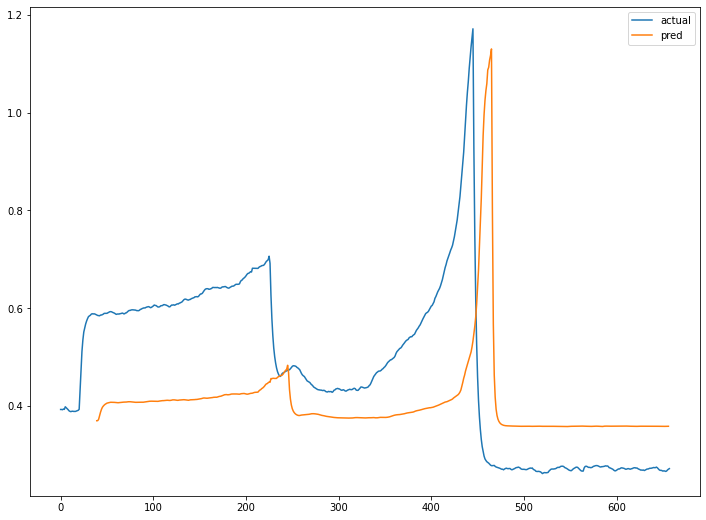

num 0 [32.2478362] actual [0.27065132] prediction [0.35758623]
오차율 : [32.2478362]
num 1 [32.31062376] actual [0.27101567] prediction [0.35754517]
오차율 : [32.31062376]
num 2 [32.08444654] actual [0.27209206] prediction [0.35759935]
오차율 : [32.08444654]
num 3 [31.90995516] actual [0.2726075] prediction [0.35760605]
오차율 : [31.90995516]
num 4 [31.74917595] actual [0.27271354] prediction [0.35768095]
오차율 : [31.74917595]
num 5 [31.89746051] actual [0.27198046] prediction [0.35772207]
오차율 : [31.89746051]
num 6 [31.64030364] actual [0.27225589] prediction [0.35775042]
오차율 : [31.64030364]
num 7 [32.15124742] actual [0.27083598] prediction [0.35769308]
오차율 : [32.15124742]
num 8 [32.42774846] actual [0.26979967] prediction [0.35774088]
오차율 : [32.42774846]
num 9 [32.51876833] actual [0.26904332] prediction [0.35765383]
오차율 : [32.51876833]
num 10 [32.91192559] actual [0.26795099] prediction [0.35758922]
오차율 : [32.91192559]
num 11 [32.93608499] actual [0.26796423] prediction [0.35754743]
오차율 : [32.936

In [239]:
df=pd.read_csv('m2_s2_bank_0765f177a52e5543a9e0a8bfc045cf6a__site_40ab7c891c559b478e96f8bb5c682ca0.csv')
df=df[df['CellNo']==20].reset_index(drop=True)
x_test2=df['ResistValue']
n_samples=len(x_test2)
x_0 = x_test2[1]

r_meas_save = np.zeros(n_samples)
r_esti_save = np.zeros(n_samples)

x_esti, P = None, None
for i in range(n_samples):
    r_meas = x_test2[i]
    if i == 0:
        x_esti, P = x_0, P_0
    else:
        x_esti, P = kalman_filter(r_meas, x_esti, P)
        # print(x_esti[1])
    r_meas_save[i] = r_meas
    r_esti_save[i] = x_esti

#print("123", x_esti)

x_test2 = r_esti_save

x_test2 = pd.DataFrame(x_test2)
x_test2.columns = scale_cols
x_test2 = scaler.fit_transform(x_test2)
x_test2 = pd.DataFrame(x_test2)
y_test2 = x_test2

train_feature2, train_label2 = make_dataset(x_test2, y_test2, 20)
predictions = model.predict(train_feature2)

# Inversing
predictions = scaler.inverse_transform(predictions)
x_test2 = scaler.inverse_transform(x_test2)


feature_len = len(x_test2)-1 
plot_len = feature_len-20

x_data = range(feature_len)
plt.figure(figsize=(12, 9))
plt.plot(x_test2[:], label ='actual')
plt.plot(x_data[plot_len:], predictions[plot_len-39:], label='predictions')
plt.legend()
plt.show()

plt.figure(figsize=(12, 9))
plt.plot(x_test2[:], label ='actual')
plt.plot(x_data[39:],predictions, label='pred')
plt.legend()
plt.show()


feature_len = len(train_feature2) - 1
plot_len = feature_len-20
error= error_rate(x_test2, predictions, plot_len, 20)
print('평균 오차율 :',error)